In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DistributedSampler, RandomSampler

from torchvision import transforms

from pytorchvideo.models import x3d
from pytorchvideo.data import Ucf101, RandomClipSampler, UniformClipSampler, Kinetics

# from torchvision.transforms._transforms_video import (
#     CenterCropVideo,
#     NormalizeVideo,
# )

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
)

from tqdm.notebook import tqdm
from collections import OrderedDict
import itertools
import os
import pickle

In [23]:
class Args:
    def __init__(self):
        self.metadata_path = '/mnt/NAS-TVS872XT/dataset/'
        self.root = self.metadata_path
        self.annotation_path = self.metadata_path
        self.FRAMES_PER_CLIP = 16
        self.STEP_BETWEEN_CLIPS = 16
        self.BATCH_SIZE = 16
        self.NUM_WORKERS = 8  # kinetics:8, ucf101:24

        self.CLIP_DURATION = (8 * 8) / 30  # (num_frames * sampling_rate)/fps
        self.VIDEO_NUM_SUBSAMPLED = 8  # 事前学習済みモデルに合わせて16→8
        self.UCF101_NUM_CLASSES = 101
        self.KINETIC400_NUM_CLASSES = 400

args = Args()

In [24]:
transform = Compose([
    ApplyTransformToKey(
        key="video",
        transform=Compose([
            UniformTemporalSubsample(args.VIDEO_NUM_SUBSAMPLED),
            transforms.Lambda(lambda x: x / 255.),
            # Normalize((0.45, 0.45, 0.45), (0.225, 0.225, 0.225)),
            ShortSideScale(size=256),
            # RandomShortSideScale(min_size=256, max_size=320,),
            # CenterCropVideo(crop_size=(256, 256)),
            CenterCrop(256),
            # RandomCrop(224),
            RandomHorizontalFlip(),
        ]),
    ),
    ApplyTransformToKey(
        key="label",
        transform=transforms.Lambda(lambda x: x),
    ),
    RemoveKey("audio"),
])

In [25]:
root_kinetics = '/mnt/NAS-TVS872XT/dataset/Kinetics400/'

# train_dataset = Kinetics(
#             data_path=root_kinetics + "train",
#             video_path_prefix=root_kinetics + "train",
#             clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
#             video_sampler=RandomSampler,
#             decode_audio=False,
#             transform=transform,
#         )

# test_dataset = Kinetics(
#             data_path=root_kinetics + "test_list.txt",
#             video_path_prefix=root_kinetics + 'test/',
#             clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
#             video_sampler=RandomSampler,
#             decode_audio=False,
#             transform=transform,
#         )

val_dataset = Kinetics(
            data_path=root_kinetics + "val",
            video_path_prefix=root_kinetics + "val",
            clip_sampler=RandomClipSampler(clip_duration=args.CLIP_DURATION),
            video_sampler=RandomSampler,
            decode_audio=False,
            transform=transform,
        )

In [26]:
class LimitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.dataset_iter = itertools.chain.from_iterable(
            itertools.repeat(iter(dataset), 2)
        )

    def __getitem__(self, index):
        return next(self.dataset_iter)

    def __len__(self):
        return self.dataset.num_videos

In [27]:
# train_loader = DataLoader(LimitDataset(train_dataset),
#                             batch_size=args.BATCH_SIZE,
#                             drop_last=True,
#                             num_workers=args.NUM_WORKERS)
# test_loader = DataLoader(LimitDataset(test_dataset),
#                             batch_size=args.BATCH_SIZE,
#                             drop_last=True,
#                             num_workers=args.NUM_WORKERS)
val_loader = DataLoader(LimitDataset(val_dataset),
                            batch_size=args.BATCH_SIZE,
                            drop_last=True,
                            num_workers=args.NUM_WORKERS)

In [78]:
data = iter(val_loader).__next__()
# print(data["video"].shape)
# print(data["video"][:1].shape)

torch.Size([16, 3, 8, 256, 256])
torch.Size([1, 3, 8, 256, 256])


In [44]:
import numpy as np
import matplotlib.pyplot as plt

# test
# img_list = []
# x = np.arange(3*8*256*256).reshape(3,8,256,256)
# print(x.shape)
# x = x.transpose(1,2,3,0)
# print(x.shape)
# for i in range(8):
#     img = x[i:i+1, :, :, :]
#     img = np.squeeze(img)
#     img_list.append(img)
# print(img_list[7].shape)

# fig = plt.figure()
# rows = 1
# cols = 8
# axes = []
# for i in range(rows*cols):
#     img = img_list[i]
#     axes.append(fig.add_subplot(rows, cols, i+1))
#     # subplot_title("frame:" + str(i))
#     # axes[-1].set_title(subplot_title)
#     plt.imshow(img)
# fig.tight_layout()
# plt.show()

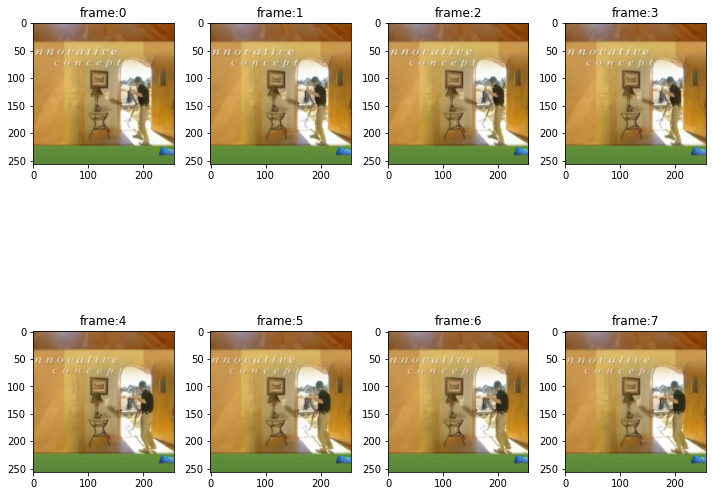

In [77]:
video = []

numpy_data = data["video"][:1].numpy()
numpy_data = np.squeeze(numpy_data)
numpy_data = numpy_data.transpose(1,2,3,0)
for i in range(8):
    img = numpy_data[i:i+1, :, :, :]
    img = np.squeeze(img)
    video.append(img)

# fig = plt.figure()
# axes = []

rows = 2
cols = 4
frame_id = 0

fig, axes = plt.subplots(rows,cols,tight_layout=True,figsize=(10,10))

for i in range(rows):
    for j in range(cols):
        img = video[i]
        subplot_title = ("frame:" + str(frame_id))
        axes[i,j].set_title(subplot_title)
        axes[i,j].imshow(img)
        frame_id = frame_id + 1
plt.show()
    

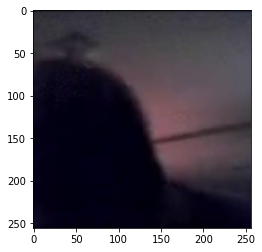

In [30]:
plt.imshow(numpy_data)
 
plt.show()